## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [ ]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [ ]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [ ]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size # Exact integer division
num_epochs = 36
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.75
epoch 2: valid acc = 0.781000018119812
epoch 3: valid acc = 0.8140000104904175
epoch 4: valid acc = 0.8270000219345093
epoch 5: valid acc = 0.8410000205039978
epoch 6: valid acc = 0.8539999723434448
epoch 7: valid acc = 0.8550000190734863
epoch 8: valid acc = 0.859000027179718
epoch 9: valid acc = 0.8650000095367432
epoch 10: valid acc = 0.8669999837875366
epoch 11: valid acc = 0.8679999709129333
epoch 12: valid acc = 0.8730000257492065
epoch 13: valid acc = 0.8730000257492065
epoch 14: valid acc = 0.8740000128746033
epoch 15: valid acc = 0.8769999742507935
epoch 16: valid acc = 0.8799999952316284
epoch 17: valid acc = 0.8849999904632568
epoch 18: valid acc = 0.8830000162124634
epoch 19: valid acc = 0.8830000162124634
epoch 20: valid acc = 0.8859999775886536
epoch 21: valid acc = 0.8859999775886536
epoch 22: valid acc = 0.8870000243186951
epoch 23: valid acc = 0.8870000243186951
epoch 24: valid acc = 0.8870000243186951
epoch 25: valid acc = 0.8859999775886536


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [ ]:
## Three layer MLP. Hypothesis: will have less error
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b3 = tf.Variable(np.zeros((20,)).astype('float32'))
        self.W  = [self.W1,self.W2,self.W3]
        self.b  = [self.b1,self.b2,self.b3]
        self.list = [self.W1,self.b1,self.W2,self.b2,self.W3,self.b3]
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        out = tf.matmul(h2, self.W3) + self.b3
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = sum(tf.nn.l2_loss(Wx) for Wx in model.W)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, model.list)

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size # Exact integer division
num_epochs = 32
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, model.list))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.26100000739097595
epoch 2: valid acc = 0.3059999942779541
epoch 3: valid acc = 0.31299999356269836
epoch 4: valid acc = 0.30799999833106995
epoch 5: valid acc = 0.4129999876022339
epoch 6: valid acc = 0.47200000286102295
epoch 7: valid acc = 0.5460000038146973
epoch 8: valid acc = 0.5690000057220459
epoch 9: valid acc = 0.5989999771118164
epoch 10: valid acc = 0.6259999871253967
epoch 11: valid acc = 0.6510000228881836
epoch 12: valid acc = 0.6690000295639038
epoch 13: valid acc = 0.6800000071525574
epoch 14: valid acc = 0.6909999847412109
epoch 15: valid acc = 0.703000009059906
epoch 16: valid acc = 0.7179999947547913
epoch 17: valid acc = 0.7390000224113464
epoch 18: valid acc = 0.75
epoch 19: valid acc = 0.7580000162124634
epoch 20: valid acc = 0.7620000243186951
epoch 21: valid acc = 0.7680000066757202
epoch 22: valid acc = 0.7649999856948853
epoch 23: valid acc = 0.7680000066757202
epoch 24: valid acc = 0.777999997138977
epoch 25: valid acc = 0.7860000133514

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [ ]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

# END of your code
#############################################################
hidden_dim = 300
print(X_train.shape)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(X_train.shape[1], activation='relu'),
  tf.keras.layers.Dense(hidden_dim,activation='relu'),
  tf.keras.layers.Dense(20)
])

#############################################################
# TODO: compile the model, set optimizer and loss

# END of your code
#############################################################
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

#############################################################
# TODO: train the model with our own dataset

# END of your code
#############################################################
model.fit(
    x=X_train,
    y=y_train,
    epochs=6,
    validation_data=(X_test,y_test),
    verbose=2,
)


(49000, 784)
Epoch 1/6
1532/1532 - 13s - loss: 2.1009 - sparse_categorical_accuracy: 0.7848 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.7906
Epoch 2/6
1532/1532 - 11s - loss: 0.4286 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.5702 - val_sparse_categorical_accuracy: 0.8265
Epoch 3/6
1532/1532 - 11s - loss: 0.3343 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.5564 - val_sparse_categorical_accuracy: 0.8356
Epoch 4/6
1532/1532 - 11s - loss: 0.2811 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.5431 - val_sparse_categorical_accuracy: 0.8453
Epoch 5/6
1532/1532 - 11s - loss: 0.2459 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.5487 - val_sparse_categorical_accuracy: 0.8406
Epoch 6/6
1532/1532 - 11s - loss: 0.2195 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.5704 - val_sparse_categorical_accuracy: 0.8381


## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [8]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [9]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [10]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

3.0178426252625616
The 100 th loop cost: 11.709930441322761, computation time: 2.0323095321655273
The 200 th loop cost: 0.5247286334855129, computation time: 4.061134576797485
The 300 th loop cost: 0.49432758148603245, computation time: 5.977334022521973
The 400 th loop cost: 0.4894183657888568, computation time: 7.893779993057251
The 500 th loop cost: 0.488285852853099, computation time: 9.84467363357544
The 600 th loop cost: 0.48789831527952865, computation time: 11.789960861206055
The 700 th loop cost: 0.4877654083747402, computation time: 13.78913140296936
The 800 th loop cost: 0.4877137106943249, computation time: 15.735889673233032
The 900 th loop cost: 0.4876910131017615, computation time: 17.700416803359985
The 1000 th loop cost: 0.4876802854885455, computation time: 19.620908975601196
it takes 20.50989580154419 seconds


X (500, 784)
labels (500,)


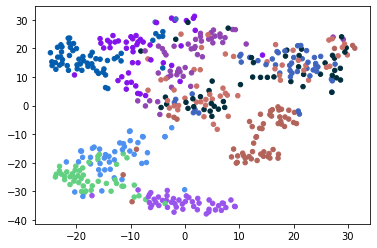

In [15]:
## visualize tSNE of original data
labels = y_test[random_select]
print("X",X.shape)
print("labels",labels.shape)
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [16]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.811, new learning rate = 0.00095
epoch 2: valid acc = 0.845, new learning rate = 0.0009025
epoch 3: valid acc = 0.86, new learning rate = 0.000857375
epoch 4: valid acc = 0.866, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.871, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.88, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.87, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.872, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.886, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.886, new learning rate = 0.0005987369392383785
test acc: 0.8661


0.8661

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [17]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################

Y = tsne(X, low_dim=2, perplexity=30.0)

y = model.predict(X)



#Y = tsne(X, low_dim=2, perplexity=30.0)
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

/content/e4040-2021fall-assign1-jcr2211/utils/features/tsne.py:16: RuntimeWarning: invalid value encountered in true_divide
  P = P / np.sum(P)


769.5500204856814
The 100 th loop cost: 11.746954215474142, computation time: 1.9837779998779297
The 200 th loop cost: 0.5336657378464762, computation time: 4.00252890586853
The 300 th loop cost: 0.5032787354285404, computation time: 5.983379364013672
The 400 th loop cost: 0.49849158795414045, computation time: 7.987473726272583
The 500 th loop cost: 0.4975643528366752, computation time: 9.983659029006958
The 600 th loop cost: 0.49727080582796696, computation time: 11.961416959762573
The 700 th loop cost: 0.49715691370238274, computation time: 13.944029092788696
The 800 th loop cost: 0.49710564613655367, computation time: 15.907355785369873
The 900 th loop cost: 0.4970828605120834, computation time: 17.91791081428528
The 1000 th loop cost: 0.49707177496193367, computation time: 19.92329740524292
it takes 21.36467981338501 seconds


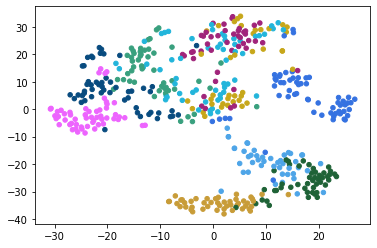

In [18]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################

labels = y
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [44]:
# Tune the parameter, show the results.
# run tSNE

from utils.features.tsne import pca_preprocess
X = X_test[random_select]
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

y = model.predict(X)

#X = pca_preprocess(X,50)
Y = tsne(X, low_dim=2, perplexity=34.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

/content/e4040-2021fall-assign1-jcr2211/utils/features/tsne.py:16: RuntimeWarning: invalid value encountered in true_divide
  P = P / np.sum(P)


794.0827287576219
The 100 th loop cost: 11.575084862380704, computation time: 1.975301742553711
The 200 th loop cost: 0.5027211426440682, computation time: 3.959671974182129
The 300 th loop cost: 0.4784923385602835, computation time: 5.956455945968628
The 400 th loop cost: 0.4752618097602141, computation time: 7.938288450241089
The 500 th loop cost: 0.47471694836446837, computation time: 9.900225639343262
The 600 th loop cost: 0.47458326619159596, computation time: 11.87138032913208
The 700 th loop cost: 0.47454238608139, computation time: 13.855925798416138
The 800 th loop cost: 0.47452878260866693, computation time: 15.819687128067017
The 900 th loop cost: 0.4745239990472487, computation time: 17.826199054718018
The 1000 th loop cost: 0.47452227850655737, computation time: 19.80903458595276
it takes 977.5191190242767 seconds


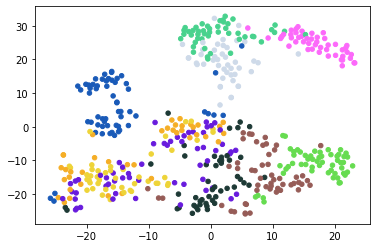

In [46]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################